In [8]:
from models import KMeansClassifier, LinearClassifier
import torchvision
import torchvision.transforms as tvtf
import torch
from torch.nn import DataParallel
from torch.utils.data import DataLoader

from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
batch_size = 256
data_root = '~/.pytorch-datasets'

ds_train_mnist = torchvision.datasets.MNIST(data_root, train=True, transform=tvtf.ToTensor(), download=True)
ds_test_mnist = torchvision.datasets.MNIST(data_root, train=False, transform=tvtf.ToTensor(), download=True)

dl_train_mnist = DataLoader(ds_train_mnist, batch_size, shuffle=True)
dl_test_mnist = DataLoader(ds_test_mnist, batch_size, shuffle=True)

ds_train_fashionmnist = torchvision.datasets.FashionMNIST(data_root, train=True, transform=tvtf.ToTensor(), download=True)
ds_test_fashionmnist = torchvision.datasets.FashionMNIST(data_root, train=False, transform=tvtf.ToTensor(), download=True)

dl_train_fashionmnist = DataLoader(ds_train_fashionmnist, batch_size, shuffle=True)
dl_test_fashionmnist = DataLoader(ds_test_fashionmnist, batch_size, shuffle=True)

ds_train_cifar = torchvision.datasets.CIFAR10(data_root, train=True, transform=tvtf.ToTensor(), download=True)
ds_test_cifar = torchvision.datasets.CIFAR10(data_root, train=False, transform=tvtf.ToTensor(), download=True)

dl_train_cifar = DataLoader(ds_train_cifar, batch_size, shuffle=True)
dl_test_cifar = DataLoader(ds_test_cifar, batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
def loss_fn(y_pred, y_true):
    return torch.nn.functional.cross_entropy(y_pred, y_true)

In [11]:
def train(model, optimizer, dl_train, dl_test, num_epochs=60):
    temperature = 100

    num_samples = len(dl_train.sampler)
    num_batches = len(dl_train.batch_sampler)
    num_test_samples = len(dl_test.sampler)

    best_accuracy = 0
    
    global train_accuracies, train_losses, test_accuracies, test_losses
    train_accuracies = []
    train_losses = []
    test_accuracies = []
    test_losses = []

    with tqdm(total=num_batches, bar_format='{l_bar}{bar}{r_bar}') as pbar:
        for epoch in range(num_epochs):
            pbar.reset()
            pbar.set_description(f'Epoch {epoch + 1}/{num_epochs}')
            pbar.refresh()

            num_correct = 0
            for i, (x_train, y_train) in enumerate(dl_train, 0):
                x_train = x_train.to(device)
                y_train = y_train.to(device)

                optimizer.zero_grad()

                r = model(x_train)
                y_pred = torch.softmax(temperature * r, dim=1)
                loss = loss_fn(y_pred, y_train)
                loss.backward()
                optimizer.step()
                num_correct += (y_pred.argmax(axis=1) == y_train).sum().item()
                pbar.update()
                accuracy = 100. * num_correct / num_samples

            train_accuracies.append(accuracy)
            train_losses.append(loss.item())
            best_accuracy = max(best_accuracy, accuracy)
            pbar.set_postfix(dict(accuracy=accuracy, best_accuracy=best_accuracy), loss=loss.item())

            num_correct = 0
            for i, (x_test, y_test) in enumerate(dl_test, 0):
                x_test = x_test.to(device)
                y_test = y_test.to(device)
                r = model(x_test)
                y_pred = torch.softmax(temperature * r, dim=1)
                loss = loss_fn(y_pred, y_test)
                num_correct += (y_pred.argmax(axis=1) == y_test).sum().item()
                accuracy = 100. * num_correct / num_test_samples
            test_losses.append(loss)
            test_accuracies.append(accuracy)

In [12]:
def plot_all(title):
    fig, axes=plt.subplots(2,2, figsize=(12,8))
    fig.suptitle(title)
    axes[0,0].plot(train_losses)
    axes[0,0].set_xlabel('epoch')
    axes[0,0].set_title('train loss')
    axes[0,1].plot(train_accuracies)
    axes[0,1].set_xlabel('epoch')
    axes[0,1].set_title('train accuracy')
    axes[1,0].plot(test_losses)
    axes[1,0].set_xlabel('epoch')
    axes[1,0].set_title('test loss')
    axes[1,1].plot(test_accuracies)
    axes[1,1].set_xlabel('epoch')
    axes[1,1].set_title('test accuracy')
    plt.tight_layout()
    fig.show()

In [13]:
out_channels = 512
K = 10
cluster_temp = 50
learning_rate = 0.01

## Experiments

### Classifier with KMeans layer

In [6]:
in_dims = ds_train_mnist.data[0].shape
model = KMeansClassifier(in_dims, out_channels, K, cluster_temp)
model = DataParallel(model).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=5e-4, momentum=0.9)

train(model, optimizer, dl_train_mnist, dl_test_mnist)

Epoch 60/60: 100%|██████████| 235/235 [00:12<00:00, 18.42it/s, accuracy=90, best_accuracy=92.1, loss=1.75]  


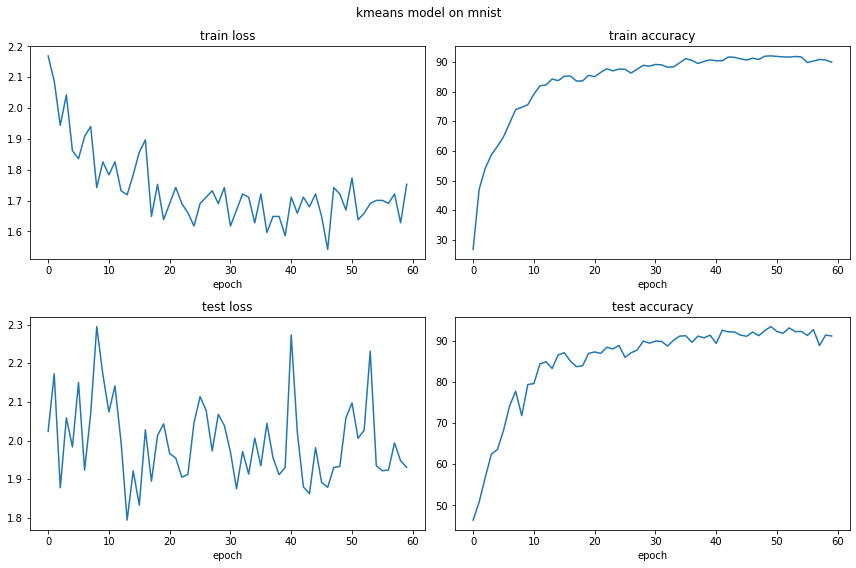

In [7]:
plot_all('kmeans model on mnist')

In [8]:
in_dims = ds_train_fashionmnist.data[0].shape
model = KMeansClassifier(in_dims, out_channels, K, cluster_temp)
model = DataParallel(model).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=5e-4, momentum=0.9)

train(model, optimizer, dl_train_fashionmnist, dl_test_fashionmnist)

Epoch 60/60: 100%|██████████| 235/235 [00:13<00:00, 18.00it/s, accuracy=74, best_accuracy=74.7, loss=1.97]  


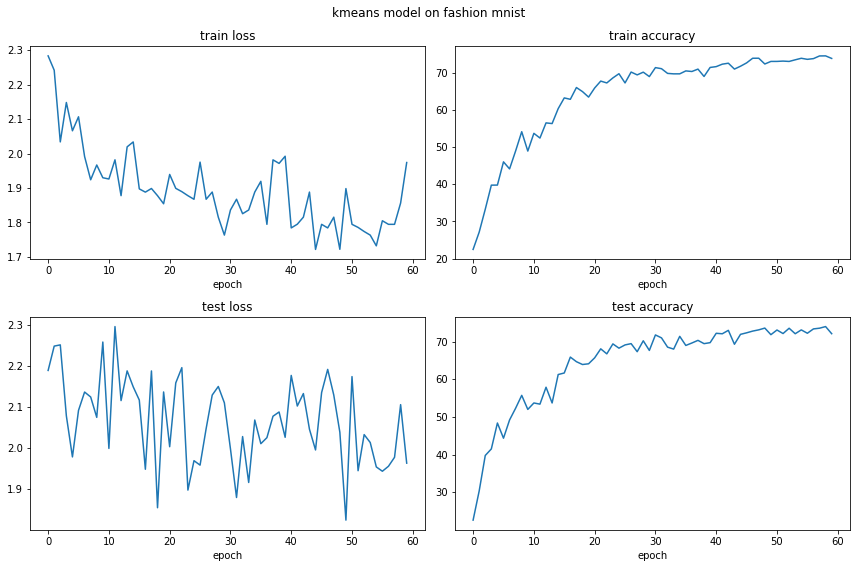

In [9]:
plot_all('kmeans model on fashion mnist')

In [6]:
in_dims = ds_train_cifar.data[0].shape
model = KMeansClassifier(in_dims, out_channels, K, cluster_temp)
model = DataParallel(model).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=5e-4, momentum=0.9)

train(model, optimizer, dl_train_cifar, dl_test_cifar)

Epoch 60/60: 100%|██████████| 196/196 [00:14<00:00, 13.16it/s, accuracy=19.6, best_accuracy=20, loss=2.27]  


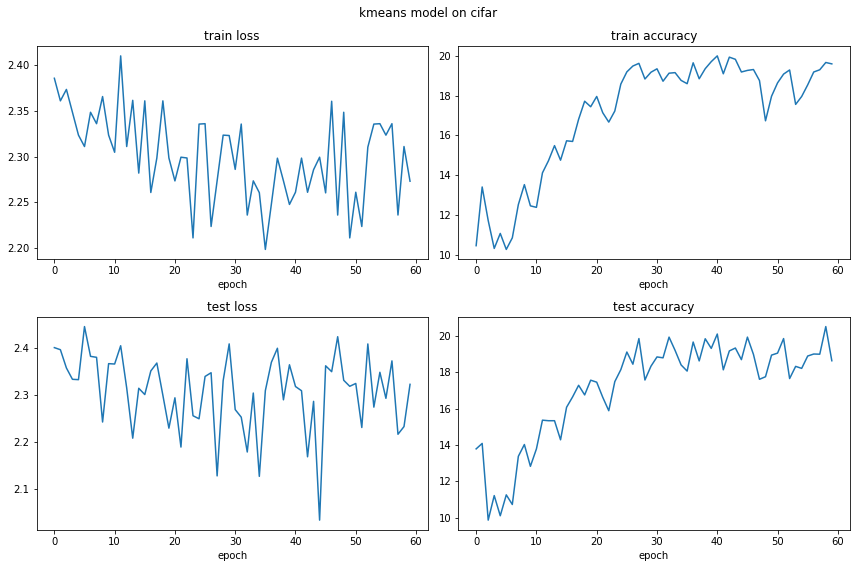

In [7]:
plot_all('kmeans model on cifar')

### Classifier with linear layer

In [9]:
in_dims = ds_train_mnist.data[0].shape
model = LinearClassifier(in_dims, out_channels, K)
model = DataParallel(model).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=5e-4, momentum=0.9)

train(model, optimizer, dl_train_mnist, dl_test_mnist, 20)

Epoch 20/20: 100%|██████████| 235/235 [00:13<00:00, 16.97it/s, accuracy=97.7, best_accuracy=97.7, loss=1.5] 


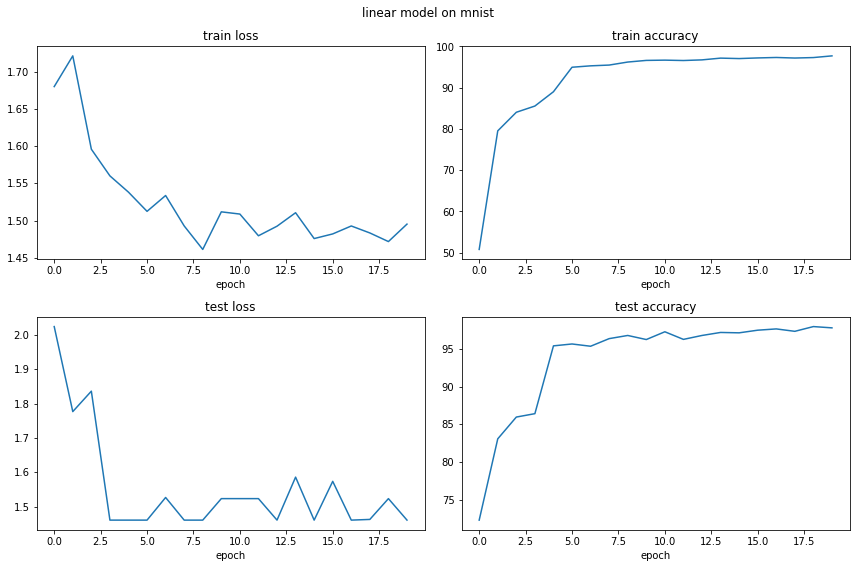

In [11]:
plot_all('linear model on mnist')

In [26]:
in_dims = ds_train_fashionmnist.data[0].shape
model = LinearClassifier(in_dims, out_channels, K)
model = DataParallel(model).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=5e-4, momentum=0.9)

train(model, optimizer, dl_train_fashionmnist, dl_test_fashionmnist, 20)

Epoch 20/20: 100%|██████████| 235/235 [00:13<00:00, 17.03it/s, accuracy=68, best_accuracy=68, loss=1.75]    


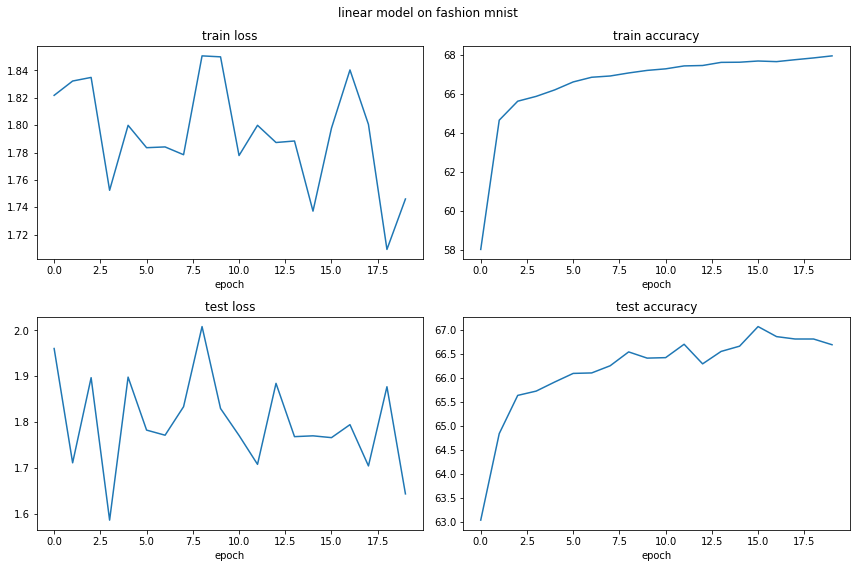

In [27]:
plot_all('linear model on fashion mnist')